# Cyberbullying Detection Project

**Project Overview:**
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached
all-time highs. We can combat this by creating models to automatically flag potentially
harmful tweets as well as break down the patterns of hatre

**Project Description:**
As social media usage becomes increasingly prevalent in every age group, a vast majority of
citizens rely on this essential medium for day-to-day communication. Social media’s
ubiquity means that cyberbullying can effectively impact anyone at any time or anywhere,
and the relative anonymity of the internet makes such personal attacks more difficult to
stop than traditional bullying.
On April 15th, 2020, UNICEF issued a warning in response to the increased risk of
cyberbullying during the COVID-19 pandemic due to widespread school closures, increased
screen time, and decreased face-to-face social interaction. The statistics of cyberbullying
are outright alarming: 36.5% of middle and high school students have felt cyberbullied and
87% have observed cyberbullying, with effects ranging from decreased academic
performance to depression to suicidal thoughts.
In light of all of this, this dataset (i.e., cyberbullying_tweets.csv) contains more than 47,000
tweets labelled according to the class of cyberbullying:
• Age;
• Ethnicity;
• Gender;
• Religion;
• Other type of cyberbullying;• Not cyberbullyingd.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
#nltk.download('stopwords')
#nltk.download('punkt')
from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
df = pd.read_csv('cyberbullying_tweets.csv', delimiter=',', encoding='utf-8', header=0)
df = df[~df.duplicated()] # remove duplicates

In [3]:
df.head()
df.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


In [4]:
df.groupby('cyberbullying_type').describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47656 non-null  object
 1   cyberbullying_type  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [5]:
df.shape

(47656, 2)

In [6]:

df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [7]:
df.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

##### **Preprocessing**



In [8]:
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    text = re.sub(r'rt', '', text, flags=re.IGNORECASE) #remove retweet 
    text = re.sub(r'http\S+', '', text)   #remove URLs
    text = re.sub(r'@[^\s]+','',text) #remove users of tweet (@user) not usefull 
    text = re.sub(r'[^a-zA-Z\s]', '', text)   #remove special characters & punctuation
    text = text.lower()   #convert text to lowercase
    tokens = word_tokenize(text)   #tokenization
    
    #remove stopwords
    stop_words = set(stopwords.words('english')) 
    tokens = [word for word in tokens if word not in stop_words]
    
    #stemming
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    #join tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

#example usage

example_text = df['tweet_text'][100]
print(example_text)
processed_example = preprocess_text(example_text)
print(processed_example)

@mirebotan84 @RamiAlLolah I support that. I don't like people like Rami who complain about the things he supports when done to others.
suppo dont like people like ramus complain thing suppos done others


In [9]:
# tweets are preprocessed and cleaned
df['clean_tweet'] = df['tweet_text'].apply(lambda x: preprocess_text(x))
# classifications of cyberbullying are assigned a value 0-5
df['cyberbullying_type'] = df['cyberbullying_type'].apply(lambda x:  {'not_cyberbullying': 0, 'gender': 1, 'religion': 2, 'age': 3, 'ethnicity': 4, 'other_cyberbullying': 5}[x])

In [10]:
#Delete long and short tweets

df['text_len'] = [len(word_tokenize(tweet)) for tweet in df['clean_tweet']]
df = df[(df['text_len'] < 50) & (df['text_len'] > 2)]

In [11]:
df.drop_duplicates("clean_tweet", inplace = True)

##### **Data Split**



In [12]:
from sklearn.model_selection import train_test_split
# partition X and y
X = df['clean_tweet']
y = df['cyberbullying_type']


In [13]:
# split dataset for testing, training, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,shuffle = True, random_state = 40)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size =  0.2,shuffle = True, random_state = 40)

In [14]:
#Look at if classes are inbalanced
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))

(array([0, 1, 2, 3, 4, 5], dtype=int64), array([4443, 4745, 5080, 4987, 4923, 3380], dtype=int64))
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([1107, 1200, 1243, 1288, 1212,  840], dtype=int64))


In [15]:
#Oversample Data as classes are inbalanced
from imblearn.over_sampling import RandomOverSampler

ros_train = RandomOverSampler()
X_train, y_train = ros_train.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

ros_valid = RandomOverSampler()
X_valid, y_valid = ros_valid.fit_resample(np.array(X_valid).reshape(-1,1), np.array(y_valid).reshape(-1,1))

train_data = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['clean_tweet', 'cyberbullying_type']);
valid_data = pd.DataFrame(list(zip([x[0] for x in X_valid], y_valid)), columns = ['clean_tweet', 'cyberbullying_type']);

X_train = train_data["clean_tweet"]
y_train = train_data["cyberbullying_type"]

X_valid = valid_data["clean_tweet"]
y_valid = valid_data["cyberbullying_type"]

In [16]:
# Check training, validation, and testing sizes
print("Training set size: ", len(X_train))
print("Validation set size: ", len(X_valid))
print("Testing set size: ", len(X_test))

Training set size:  30480
Validation set size:  7728
Testing set size:  8612


##### **Model Establishment**



**Naive Model**

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

target_names = ['not_cyberbullying', 'gender', 'religion','age','ethnicity','other_cyberbullying']

vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X_train)
model = LogisticRegression(max_iter = 1000)
model.fit(X_vect, y_train)

X_test_vec = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vec)


print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

  not_cyberbullying       0.67      0.62      0.64      1395
             gender       0.93      0.84      0.89      1449
           religion       0.95      0.94      0.94      1621
                age       0.94      0.97      0.96      1600
          ethnicity       0.97      0.97      0.97      1599
other_cyberbullying       0.55      0.66      0.60       948

           accuracy                           0.85      8612
          macro avg       0.83      0.83      0.83      8612
       weighted avg       0.86      0.85      0.85      8612



In [17]:
from gensim.models.keyedvectors import KeyedVectors


path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(path, binary = True)


In [15]:
#Load your training, validation, testing sets into the Pythorch environment.
#Transform each text into a matrix (e.g., a sequence of word embeddings) in the PyTorch environment
import torch

def apply_word_embeddings(tweet, model):
    tweet = word_tokenize(tweet)
    word_embeddings = [model[word] for word in tweet if word in model]
    if len(word_embeddings) == 0: #if no words appear in the word2vec model
        return torch.zeros(1, word2vec.vector_size)
    else:
        word_embeddings = np.array(word_embeddings)
        return torch.tensor(word_embeddings)


X_train_embed = [apply_word_embeddings(tweet, word2vec) for tweet in X_train]
X_test_embed = [apply_word_embeddings(tweet, word2vec) for tweet in X_test]
X_valid_embed = [apply_word_embeddings(tweet, word2vec) for tweet in X_valid]

In [16]:
#Build RNN architecture

import torch.nn as nn
import torch.optim as optim

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Build RNN architecture

import torch.nn as nn
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden_state = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        out, _ = self.RNN(x, hidden_state)
        out = self.fc(out[:, -1, :])
        return out     
 

In [17]:
#Define Hyperparameters
hidden_size = 128
num_layers = 2
output_size = 6
embedding_size = word2vec.vector_size

#Define Model
RNN_model = RNN(embedding_size, hidden_size, num_layers, output_size)

#Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RNN_model.parameters(), lr=0.001)

In [20]:

def train(RNN_model,X_train_embed, y_train, num_epochs): 
    
    total_samples = 0
    total_correct = 0
    
    train_accuracy = []
    train_loss = []
    for epoch in range(num_epochs):
        for data, labels in zip(X_train_embed,y_train):
            optimizer.zero_grad()
            outputs = RNN_model(data.unsqueeze(0))
            loss = criterion(outputs, torch.tensor([labels]))
            loss.backward()
            optimizer.step()
    
           # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)
            total_samples += 1
            total_correct += (predicted.item() == labels)
        
        # Calculate accuracy
        accuracy = total_correct / total_samples
        train_accuracy.append(accuracy)
        train_loss.append(loss.item())
        print(f"Epoch {epoch+1}, Train Acc: {round(accuracy,4)}, Loss: {loss.item()}")

    return (train_accuracy, train_loss)


In [21]:
train_accuracy, train_loss = train(RNN_model, X_train_embed, y_train, 7)

Epoch 1, Train Acc: 0.4895, Loss: 1.7743453979492188
Epoch 2, Train Acc: 0.4211, Loss: 1.5611295700073242
Epoch 3, Train Acc: 0.4257, Loss: 1.3260982036590576
Epoch 4, Train Acc: 0.4367, Loss: 1.5060290098190308
Epoch 5, Train Acc: 0.4303, Loss: 1.5248066186904907
Epoch 6, Train Acc: 0.4246, Loss: 1.66930091381073
Epoch 7, Train Acc: 0.4278, Loss: 1.883329153060913


In [ ]:
torch.save(RNN_model.state_dict(), 'Basic_RNN_Model3.pth')

In [18]:
RNN_model = RNN(embedding_size, hidden_size, num_layers, output_size)

# Load the saved model state dictionary
RNN_model.load_state_dict(torch.load('Basic_RNN_Model(lr=0.01).pth'))


<All keys matched successfully>

In [22]:

def test_model(x_test, y_test, model):
    correct = 0
    total = 0
    y_pred = []
    with torch.no_grad():
        for data, labels in zip(X_test_embed, y_test):
            outputs = RNN_model(data.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            y_pred.append(predicted)
            total += 1
            correct += (predicted == labels).item()
    accuracy = correct/total
    return (y_pred, accuracy)

y_pred, accuracy = test_model(X_test_embed, y_test, word2vec)
print("Testing Accuracy: " + str(accuracy))

Testing Accuracy: 0.4343938690199721


In [16]:
y_pred = pd.Series([tensor.item() for tensor in y_pred])

In [17]:
# Compute metrics such as accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = y_test
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1-score", f1)

Accuracy 0.7565025545750116
Precision 0.7457913369381507
Recall 0.7383212078333906
F1-score 0.7273280337902457


In [ ]:
from sklearn.metrics import classification_report
target_names = ['not_cyberbullying', 'gender', 'religion','age','ethnicity','other_cyberbullying']
cm = classification_report(y_true, y_pred, target_names=target_names, output_dict = True)
print(cm)


In [ ]:
def predict_class(tweet):
    RNN_model.eval()
    with torch.no_grad():
        example_tweet_embedding = apply_word_embeddings(tweet, word2vec)
        output = RNN_model(example_tweet_embedding.unsqueeze(0))
        _, predicted_class = torch.max(output, 1)
        predicted_class = predicted_class.item()
    print(f"The model predicts that the example tweet is of class:  {target_names[predicted_class]}")
predict_class(tweet)

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm).iloc[:-1,:].T, annot = True,  fmt='.2f')

**GRU**

In [18]:
from tensorflow.keras.layers import Embedding, GRU, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_tweet'])

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 50

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

y_train = to_categorical(y_train)
y_valid= to_categorical(y_valid)
y_test = to_categorical(y_test)

In [19]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, word2vec.vector_size))

word_index = tokenizer.word_index

for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        pass

In [20]:

#embedding_weights = tf.constant(embedding_matrix)
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.0001

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model = Sequential([
    Embedding(input_dim = len(tokenizer.word_index)+1, output_dim = 300, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_length=maxlen),
    GRU(units = 256),
    Dense(units = 64, activation = "relu"),
    Dense(units = 6, activation = "softmax")
])

model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(X_train, y_train, verbose=0,validation_data=(X_valid, y_valid), batch_size=16,epochs = 10)
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: " + str(accuracy))
          

C:\Users\satye\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8432 - loss: 0.7655
Test Accuracy: 0.8460288047790527


[1.093878984451294, 0.4769077003002167, 0.4003141522407532, 0.3498110771179199, 0.3072260916233063]
[0.5532676577568054, 0.46568262577056885, 0.43944239616394043, 0.42779675126075745, 0.43385380506515503]


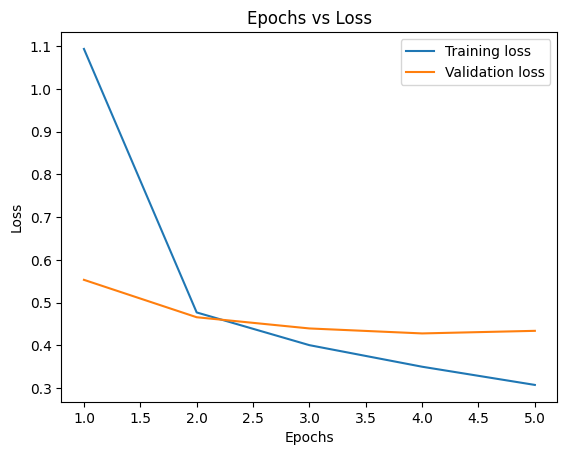

In [36]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(train_loss)
print(val_loss)
plt.plot(range(1, 6), train_loss, label = "Training loss")
plt.plot(range(1, 6), val_loss, label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()


In [19]:
model.save('BEST_GRU_MODEL.keras')

In [21]:
# Compute metrics such as accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test to class labels
y_true_classes = y_test.argmax(axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

target_names = ['not_cyberbullying', 'gender', 'religion','age','ethnicity','other_cyberbullying']
cm = classification_report(y_true_classes, y_pred_classes, target_names=target_names)


print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
                     precision    recall  f1-score   support

  not_cyberbullying       0.69      0.53      0.60      1395
             gender       0.86      0.86      0.86      1449
           religion       0.94      0.94      0.94      1621
                age       0.96      0.98      0.97      1600
          ethnicity       0.97      0.97      0.97      1599
other_cyberbullying       0.53      0.69      0.60       948

           accuracy                           0.85      8612
          macro avg       0.83      0.83      0.82      8612
       weighted avg       0.85      0.85      0.85      8612

Accuracy: 0.8460287970274036
Precision: 0.8252042419993874
Recall: 0.8287605422108344
F1-score: 0.8233068663480679


C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


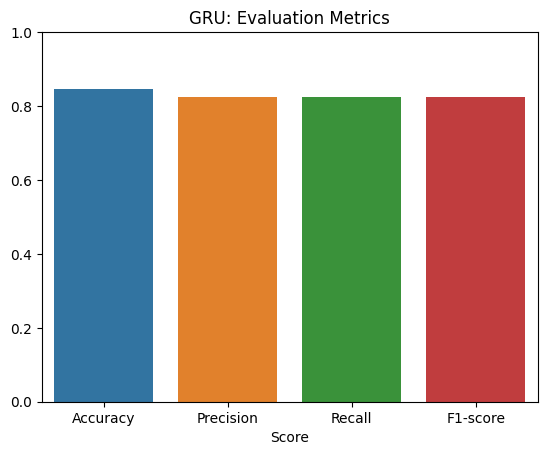

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Create a bar plot
sns.barplot(x=metrics, y=values)
plt.xlabel('Score')
plt.ylim(0,1)
plt.title('GRU: Evaluation Metrics')
plt.show()

C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


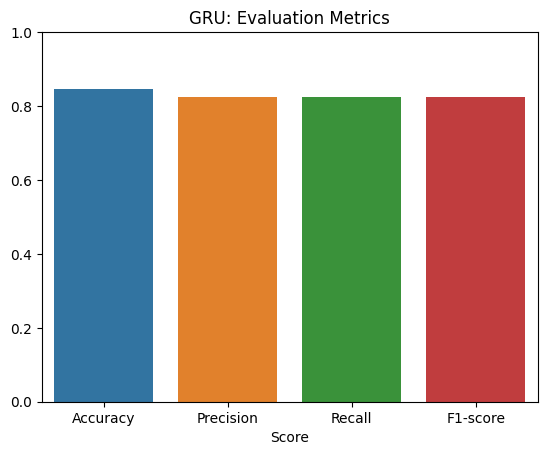

In [34]:

# Create a bar plot
sns.barplot(x=metrics, y=values)
plt.xlabel('Score')
plt.ylim(0,1)
plt.title('GRU: Evaluation Metrics')
plt.show()

C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'GRU Learning Rate vs. Accuracy')

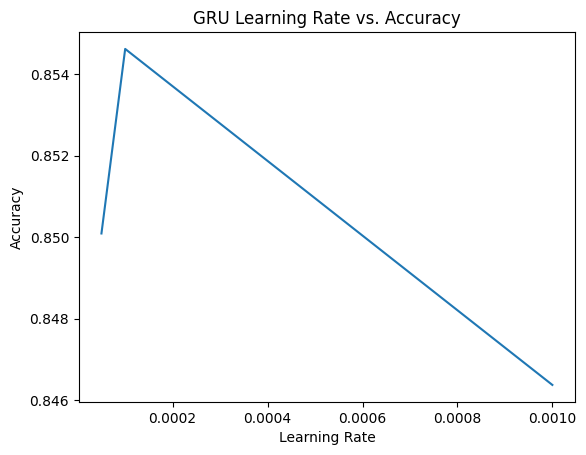

In [38]:
learning_rate = [0.001, 0.0001, 0.00005]
accuracy = [0.8463771481653507, 0.8546214584300975, 0.8500928936367859]

sns.lineplot(x = learning_rate, y = accuracy)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("GRU Learning Rate vs. Accuracy")

**BERT Transformer**

In [17]:
#Libraries needed for BERT Transformer
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import BertTokenizer, BertForSequenceClassification


In [18]:
#Load pretrained BERT Transfomer model

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
X_train_list = list(X_train.values)
X_test_list = list(X_test.values)
X_valid_list = list(X_valid.values)

X_train_tokenized = tokenizer(X_train_list, padding = True, truncation = True, max_length = 50)
X_valid_tokenized = tokenizer(X_valid_list, padding = True, truncation = True, max_length = 50)
X_test_tokenized = tokenizer(X_test_list, padding = True, truncation = True, max_length = 50)

In [20]:
#Create custom Dataset for our twitter data
import torch
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [21]:
y_train_data = list(y_train.values)
y_valid_data = list(y_valid.values)
y_test_data = list(y_test.values)

train_dataset = Dataset(X_train_tokenized, y_train_data)
val_dataset = Dataset(X_valid_tokenized, y_valid_data)
test_dataset = Dataset(X_test_tokenized,y_test_data)

In [22]:
target_names = ['not_cyberbullying', 'gender', 'religion','age','ethnicity','other_cyberbullying']
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
def compute_metrics(p):
    logits, labels = p
    pred = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(y_true = labels, y_pred = pred)
    precision = precision_score(y_true = labels, y_pred = pred, average='macro')
    recall = recall_score(y_true = labels, y_pred = pred, average='macro')
    f1 = f1_score(y_true = labels, y_pred = pred, average='macro')
    class_matrix = classification_report(y_true = labels, y_pred = pred, target_names=target_names)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1,"Classification Matrix":class_matrix}

In [42]:

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    learning_rate = 2e-5,
    per_device_train_batch_size=32,
    metric_for_best_model='accuracy',
    load_best_model_at_end=True,  # Load the best model based on validation metric
    evaluation_strategy='epoch',
    save_strategy='epoch',
)

# Initialize EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Create Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping],  # Add the early stopping callback
    compute_metrics=compute_metrics,
)

In [23]:
model = BertForSequenceClassification.from_pretrained('BertTransformerModel2 (lr = 2e-5)')

[]


In [25]:
trainer.train()

C:\Users\satye\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Classification matrix
1,0.539500,0.392154,0.848214,0.849323,0.848214,0.846330,precision recall f1-score support not_cyberbullying 0.68 0.54 0.60 1288 gender 0.87 0.87 0.87 1288 religion 0.95 0.95 0.95 1288 age 0.99 0.97 0.98 1288 ethnicity 0.96 0.98 0.97 1288 other_cyberbullying 0.64 0.78 0.70 1288 accuracy 0.85 7728 macro avg 0.85 0.85 0.85 7728 weighted avg 0.85 0.85 0.85 7728
2,0.300200,0.364892,0.859084,0.862280,0.859084,0.860424,precision recall f1-score support not_cyberbullying 0.64 0.69 0.67 1288 gender 0.90 0.86 0.88 1288 religion 0.96 0.95 0.95 1288 age 0.99 0.97 0.98 1288 ethnicity 0.98 0.99 0.98 1288 other_cyberbullying 0.70 0.69 0.70 1288 accuracy 0.86 7728 macro avg 0.86 0.86 0.86 7728 weighted avg 0.86 0.86 0.86 7728
3,0.157000,0.468976,0.858307,0.858292,0.858307,0.858088,precision recall f1-score support not_cyberbullying 0.64 0.67 0.66 1288 gender 0.88 0.88 0.88 1288 religion 0.95 0.96 0.95 1288 age 0.98 0.97 0.98 1288 ethnicity 0.99 0.99 0.99 1288 other_cyberbullying 0.71 0.67 0.69 1288 accuracy 0.86 7728 macro avg 0.86 0.86 0.86 7728 weighted avg 0.86 0.86 0.86 7728


Trainer is attempting to log a value of "                     precision    recall  f1-score   support

  not_cyberbullying       0.68      0.54      0.60      1288
             gender       0.87      0.87      0.87      1288
           religion       0.95      0.95      0.95      1288
                age       0.99      0.97      0.98      1288
          ethnicity       0.96      0.98      0.97      1288
other_cyberbullying       0.64      0.78      0.70      1288

           accuracy                           0.85      7728
          macro avg       0.85      0.85      0.85      7728
       weighted avg       0.85      0.85      0.85      7728
" of type <class 'str'> for key "eval/Classification Matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "                     precision    recall  f1-score   support

  not_cyberbullying       0.64      0.69      0.67      1288
             

TrainOutput(global_step=2859, training_loss=0.30708744493386425, metrics={'train_runtime': 8777.446, 'train_samples_per_second': 10.418, 'train_steps_per_second': 0.326, 'total_flos': 2349583882992000.0, 'train_loss': 0.30708744493386425, 'epoch': 3.0})

In [43]:

result = trainer.evaluate(eval_dataset = test_dataset)

KeyboardInterrupt: 

In [27]:
trainer.save_model('BertTransformerModel(lr = 1e-4)')

C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'GRU Learning Rate vs. Accuracy')

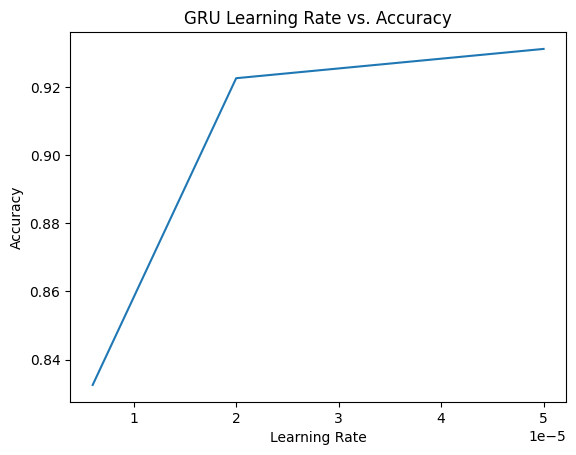

In [54]:
learning_rate = [0.00002, 0.00005, 0.000006]
accuracy = [0.9225499303297724, 0.9311425917324663, 0.832559219693451]

sns.lineplot(x = learning_rate, y = accuracy)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("GRU Learning Rate vs. Accuracy")

0.8799349744542498


C:\Users\satye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


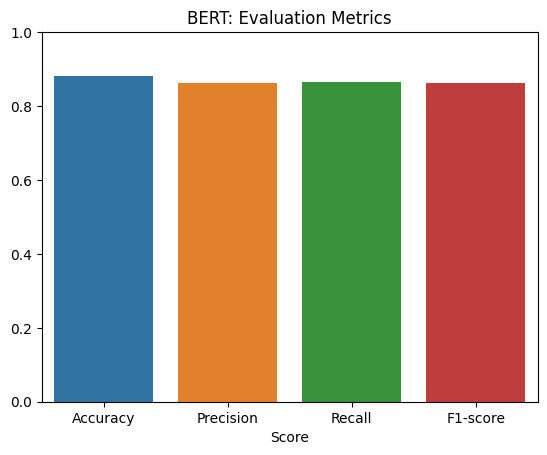

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

bert_accuracy = result['eval_accuracy']
bert_precision = result['eval_precision']
bert_recall = result['eval_recall']
bert_f1 = result['eval_f1']
bert_classification = result['eval_Classification Matrix']

print(bert_accuracy)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [bert_accuracy, bert_precision, bert_recall, bert_f1]

# Create a bar plot
sns.barplot(x=metrics, y=values)
plt.xlabel('Score')
plt.ylim(0,1)
plt.title('BERT: Evaluation Metrics')
plt.show()



In [30]:
print(bert_classification)

                     precision    recall  f1-score   support

  not_cyberbullying       0.70      0.68      0.69      1395
             gender       0.92      0.88      0.90      1449
           religion       0.96      0.95      0.96      1621
                age       0.99      0.98      0.98      1600
          ethnicity       0.99      0.99      0.99      1599
other_cyberbullying       0.62      0.71      0.66       948

           accuracy                           0.88      8612
          macro avg       0.86      0.86      0.86      8612
       weighted avg       0.88      0.88      0.88      8612



In [9]:
pip install tf_keras

  Using cached tf_keras-2.16.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.1 MB 1.1 MB/s eta 0:00:01
   ----- ---------------------------------- 0.2/1.1 MB 1.5 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.1 MB 2.5 MB/s eta 0:00:01
   --------------------- ------------------ 0.6/1.1 MB 3.1 MB/s eta 0:00:01
   ---------------------------------- ----- 1.0/1.1 MB 4.0 MB/s eta 0:00:01
   -------------------------------------- - 1.1/1.1 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
Note: you may need to restart the kernel to use updated packa

Compare Performance of Different Models

**Model Explanation: BERT Shap Method**

In [65]:
import nlp
import numpy as np
import scipy as sp
import torch
import transformers

import shap

# # load a BERT sentiment analysis model
# tokenizer = BertTokenizer.from_pretrained(
#     "BertTransformerModel"
# )
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 6)

# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=96, truncation=True)
            for v in x
        ]
    )
    outputs = model(tv)[0].detach().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val


# # build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# # explain the model's predictions 
shap_values = explainer(X_train[500:510], fixed_context=1)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [00:31<00:00,  2.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [00:36,  4.58s/it]                        


In [68]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.htmlhttps://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html

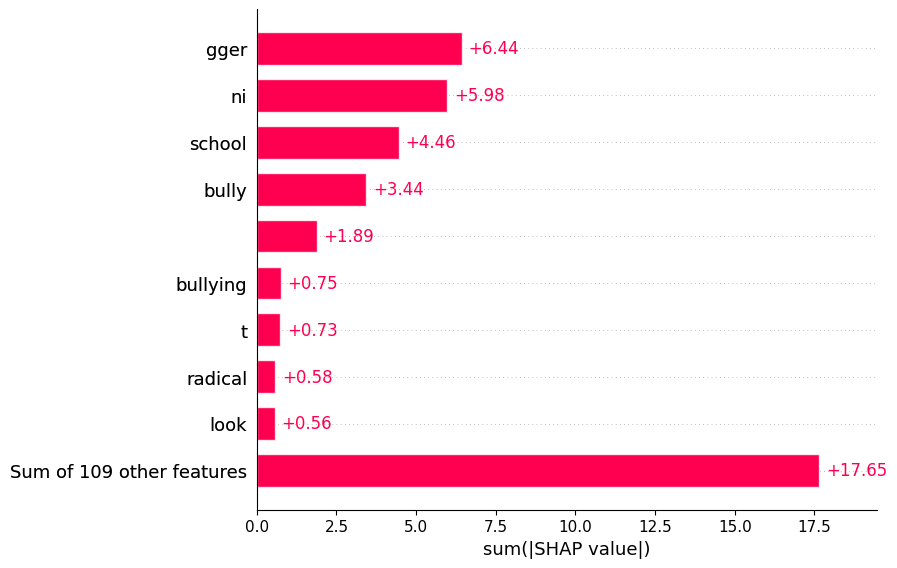

In [63]:
shap.plots.bar(shap_values.abs.sum(0))

In [67]:
shap.plots.text(shap_values)